# 공정성의 정량적 측정값 설명하기

이 실습 문서에서는 설명 가능한 AI 방법을 공정성 측정과 연결하고 최신 설명 가능성 방법이 정량적 공정성 측정 지표의 유용성을 어떻게 향상시킬 수 있는지 보여줍니다. 설명 가능한 AI 도구로 널리 사용되는 [SHAP](http://github.com/slundberg/shap)을 사용하면 공정성 측정값을 분해하고 각 모델의 입력 기능 간에 관찰된 불균형에 대한 책임을 할당할 수 있습니다. 이러한 정량적 공정성 지표를 설명하면 공정성 지표를 불투명한 공정성 기준으로 사용하는 우려를 줄일 수 있으며, 대신 모델 행동이 그룹 간에 어떻게 다른지 이해하기 위한 도구로 정보에 기반한 사용을 촉진할 수 있습니다.

정량적 공정성 지표는 머신 러닝의 공정성 정의에 수학적 정밀성을 부여하고자 합니다[[1](https://books.google.com/books/about/The_Ethical_Algorithm.html?id=QmmtDwAAQBAJ&source=kp_book_description)]. 그러나 공정성에 대한 정의는 인간의 윤리적 원칙과 머신러닝 모델이 사용되는 맥락에 따라 크게 달라지는 가치 판단에 깊이 뿌리를 두고 있습니다. 이러한 가치 판단에 대한 실질적인 의존성은 정량적 공정성 측정의 수학에서 때때로 상호 양립할 수 없는 공정성 정의 사이의 트레이드 오프 집합으로 나타납니다[[2](https://arxiv.org/abs/1609.05807)]. 공정성은 상황에 따른 가치 판단에 의존하기 때문에 정량적 공정성 지표를 불투명한 블랙박스 공정성 척도로 취급하는 것은 중요한 가치 판단 선택을 모호하게 만들 수 있으므로 위험합니다.



<!--이 문서에서 다루는 내용입니다:

1. SHAP을 사용하여 다양한 모델 공정성 측정값을 설명하는 방법.
2. 다양한 시뮬레이션 시나리오에서 SHAP 공정성 설명의 모습.
3. 보호된 특징을 도입하면 라벨 편향과 특징 편향을 구분하는 데 어떻게 도움이 되는지. 
4. SHAP 공정성 설명에서 배울 수 없는 것들-->

## 모델 공정성의 다양한 척도를 설명하는 데 SHAP을 사용하는 방법

이 문서는 모델 공정성의 "올바른" 측정값을 선택하는 방법에 대한 것이 아니라, 어떤 측정값을 선택했는지에 대한 설명에 관한 것입니다. 어떤 공정성 측정지표가 가장 적합한지는 어떤 법률이 적용되는지, 머신러닝 모델의 결과가 사람들에게 어떤 영향을 미치는지, 다양한 결과와 그에 따른 트레이드오프에 어떤 가치를 부여하는지와 같은 구체적인 상황에 따라 달라집니다. 여기서는 [인구통계학적 동등성](https://fairmlbook.org/classification.html) 메트릭을 사용하는데, 이는 간단하고 불균형 영향이라는 법적 개념과 밀접하게 연관되어 있기 때문입니다. 동일한 분석을 [결정 이론 비용](https://arxiv.org/abs/1808.00023), [균등화된 확률](https://arxiv.org/pdf/1803.02453.pdf), [기회 균등](https://ttic.uchicago.edu/~nati/Publications/HardtPriceSrebro2016.pdf) 또는 [서비스 품질 균등](https://github.com/fairlearn/fairlearn/blob/master/TERMINOLOGY.md)과 같은 다른 지표에도 적용할 수 있습니다. 인구통계학적 동등성은 머신러닝 모델의 결과가 두 개 이상의 그룹 간에 동일해야 한다는 것을 의미합니다. 인구통계학적 패리티 차이는 두 샘플 그룹에서 모델 결과 사이에 얼마나 많은 차이가 있는지를 측정하는 척도입니다.

**SHAP는 모델 출력을 원래 모델 출력과 동일한 단위의 특징 속성으로 분해하므로 먼저 SHAP을 사용하여 모델 출력을 각 입력 특징별로 분해한 다음 해당 피처의 SHAP 값을 사용하여 각 입력 피처의 인구통계학적 패리티 차이(또는 다른 공정성 지표)를 개별적으로 계산할 수 있습니다.** SHAP 값은 모델의 출력에 합산되므로 SHAP 값의 인구통계학적 패리티 차이의 합은 전체 모델의 인구통계학적 패리티 차이에도 합산됩니다.

<!--설명하지 않겠습니다.

정량적 공정성 지표를 불투명한 블랙박스 공정성 척도로 취급할 때의 위험은 머신러닝 모델 자체를 불투명한 블랙박스 예측자로 취급할 때의 문제와 놀라울 정도로 유사합니다. 많은 경우 블랙박스를 사용하는 것이 합리적이지만, 사용자가 모델 동작의 이면에 있는 이유를 이해하지 못하면 중요한 문제와 가정이 숨겨져(따라서 무시될 수 있습니다 \cite{ribeiro2016should}). 이 문제에 대응하여 사용자가 최신 복잡한 모델의 동작을 이해하는 데 도움이 되는 많은 설명 가능한 AI 방법이 개발되었습니다 \cite{vstrumbelj2014explaining,ribeiro2016should,lundberg2017unified}. 여기서는 설명 가능한 AI 방법을 정량적 공정성 지표에 적용하는 방법을 살펴봅니다.-->


## 다양한 시뮬레이션 시나리오에서 SHAP 공정성 설명이 어떻게 보이는지 살펴보기

정량적 공정성 지표를 설명하는 것의 잠재적 유용성을 살펴보기 위해 신용 인수를 기반으로 한 간단한 시뮬레이션 시나리오를 고려해 보았습니다. 시뮬레이션에서는 소득 안정성, 소득 금액, 지출 억제, 일관성 등 대출의 채무 불이행 위험을 유발하는 네 가지 기본 요인이 있습니다. 이러한 기본 요소는 관찰되지 않지만 관찰 가능한 네 가지 특징인 직업 이력, 신고 소득, 신용 조회, 연체금에 다양한 영향을 미칩니다. 이 시뮬레이션을 사용하여 무작위 샘플을 생성한 다음 비선형 [XGBoost](https://xgboost.ai/) 분류기를 훈련하여 채무 불이행 확률을 예측합니다. SHAP에서 지원하는 다른 모든 모델 유형에도 동일한 프로세스가 적용되지만, 더 복잡한 모델에 대한 설명은 모델의 세부 정보를 더 많이 숨긴다는 점을 기억하세요.

성별에 따른 보고 오류를 완전히 지정된 시뮬레이션에 도입함으로써 이러한 오류로 인한 편향이 선택한 공정성 지표에 어떻게 포착되는지 관찰할 수 있습니다. 시뮬레이션 사례에서 실제 레이블(대출 불이행 여부)은 성별(공정성을 확인하기 위해 사용하는 민감한 계층)과 통계적으로 독립적입니다. 따라서 남성과 여성 간의 격차는 특징 측정 오류, 라벨링 오류 또는 모델 오류로 인해 한 그룹 또는 두 그룹이 잘못 모델링되고 있음을 의미합니다. 예측하는 실제 레이블(액세스 권한이 있는 학습 레이블과 다를 수 있음)이 고려 중인 민감한 특징과 통계적으로 독립적이지 않은 경우, 오류가 없는 완벽한 모델이라도 인구통계학적 평등성에 실패할 수 있습니다. 이러한 경우 공정성 설명은 어떤 인구통계학적 불균형의 원인이 유효한지 판단하는 데 도움이 될 수 있습니다.

<!--이 글에서는 설명 가능한 최신 AI 도구를 사용하여 모델 공정성에 대한 기존의 정량적 측정을 개선하는 방법을 살펴봅니다. 실용적이고 실습 위주이므로 관련 [노트북]에서 자유롭게 따라해 보세요. 사람들이 머신 러닝 모델의 공정성을 측정하는 방법에 대해 기본적으로 이해하고 있다고 가정합니다. 머신 러닝의 맥락에서 공정성에 대해 생각해 본 적이 없다면 XXX와 같은 기본적인 소개부터 시작하는 것이 좋습니다. 저는 여기에 이 글을 쓰는 것이 아닙니다. 확실한 의미는 아닙니다. 한 가지 더 고지할 것은 SHAP(인기 있는 설명 가능한 AI 도구)의 저자로서 설명 가능한 AI 도구의 강점과 약점에 대해 잘 알고 있지만 공정성 전문가라고 생각하지는 않는다는 것입니다. 따라서 설명 가능한 AI 도구가 모델 공정성의 정량적 측정을 어떻게 향상시킬 수 있는지에 대한 생각을 자극하는 가이드라고 생각하면 됩니다.

저는 설명 가능한 AI에 대해 꽤 잘 알고 있다고 생각하지만, 다음과 같은 질문이 있습니다. 

머신러닝 모델의 결과가 사람들에게 영향을 미칠 때마다 공정성과 동등한 대우에 대한 의문이 자연스럽게 생깁니다. 신용 인수나 범죄 예측과 같은 민감한 사용 사례의 경우 공정성의 특정 측면을 규율하는 법률도 있습니다. 공정성 문제는 새로운 이슈는 아니지만, 머신 러닝 모델이 널리 사용되면서 다음과 같은 문제가 대두되고 있습니다.  

신용 인수나 범죄 예측과 같이 민감한 사용 사례에 대해서는 법적으로 공정성 보호가 적용되기도 하지만, 서비스 품질과 같은 다른 많은 상황에서도 공정성은 중요하며, 처음에는 고려하지 않을 수도 있습니다. 머신러닝 모델의 공정성을 정량화하는 것은 최근 연구 커뮤니티에서 상당한 관심을 받고 있으며, 많은 정량적 공정성 지표가 제안되고 있습니다. 공정성에 대한 이러한 연구와 함께 머신러닝 모델의 결과물을 설명하는 것도 상당한 연구 관심을 받고 있습니다. 좋은 설명은 사용자가 모델의 동작을 이해하고 공정성을 판단할 수 있게 해주기 때문에 설명 가능성은 공정성과 복잡하게 연결되어 있습니다.

여기에서는 설명가능성 방법을 공정성 측정과 연결하고, 최근의 설명가능성 방법이 어떻게 정량적 공정성 지표를 모델의 입력 특성으로 분해하여 유용성을 높일 수 있는지 보여줍니다. 정량적 공정성 지표를 설명하면 공정성 지표를 불투명한 공정성 기준으로 의존하는 경향을 줄이고, 대신 그룹 간의 모델 행동을 이해하는 도구로 정보에 입각한 사용을 촉진할 수 있습니다.
  
이 노트북에서는 공정성의 정량적 지표를 설명하는 데 SHAP을 사용하여 그 유용성을 높일 수 있는 방법을 살펴봅니다. 이를 위해 신용 인수를 기반으로 한 간단한 시뮬레이션 시나리오를 고려합니다. 아래 시뮬레이션에는 소득 안정성, 소득 금액, 지출 억제, 일관성 등 대출 채무 불이행 위험을 유발하는 네 가지 기본 요인이 있습니다. 이러한 기본 요소는 관찰되지 않지만 관찰 가능한 네 가지 특징인 직업 이력, 신고된 소득, 신용 조회, 연체금에 다양한 방식으로 영향을 미칩니다. 이 시뮬레이션을 사용하여 무작위 샘플을 생성한 다음 비선형 그라데이션 부스팅 트리 분류기를 훈련하여 채무 불이행 확률을 예측합니다.

시뮬레이션에 성별에 따른 보고 오류를 도입하여 이러한 오류로 인한 편향이 공정성 지표에 어떻게 포착되는지 관찰할 수 있습니다. 이 분석에서는 고전적인 통계적 동등성 지표를 사용하지만, 다른 지표를 사용해도 동일한 분석이 가능합니다. 공정성 지표에 대한 자세한 설명은 [공정성 지표 패키지 문서](https://github.com/fairlearn/fairlearn/blob/master/TERMINOLOGY.md#fairness-of-ai-systems)에서 확인할 수 있습니다.-->

In [1]:
# 여기서는 다양한 대체 시나리오에서 시뮬레이션을 실행하기 위해 호출할 수 있는 함수를 정의합니다.
import scipy as sp
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import shap
%config InlineBackend.figure_format = 'retina'
def run_credit_experiment(N, job_history_sex_impact=0, reported_income_sex_impact=0, income_sex_impact=0,
                          late_payments_sex_impact=0, default_rate_sex_impact=0,
                          include_brandx_purchase_score=False, include_sex=False):
    np.random.seed(0)
    sex = np.random.randint(0, 2, N) == 1 # randomly half men and half women
    
    # 고객 품질에 영향을 미치는 네 가지 가상의 인과적 요인이 모두 0-1 사이의 동일한 단위로 척도화됩니다.
    
    income_stability = np.random.rand(N)
    income_amount = np.random.rand(N)
    if income_sex_impact > 0:
        income_amount -= income_sex_impact/90000 * sex * np.random.rand(N)
        income_amount -= income_amount.min()
        income_amount /= income_amount.max()
    spending_restraint = np.random.rand(N)
    consistency = np.random.rand(N)
    
    # 이 제품은 직관적으로 높은 고객 품질이 모든 요소에 강하고 모든 요소에서 강함 
    customer_quality = income_stability * income_amount * spending_restraint * consistency 
    
    # 직업 이력은 기본 소득 안정성 기능의 무작위 함수입니다.
    job_history = np.maximum(
        10 * income_stability + 2 * np.random.rand(N) - job_history_sex_impact * sex * np.random.rand(N)
    , 0)
    
    # 보고된 소득은 기본 소득 금액 기능의 무작위 함수입니다.
    reported_income =  np.maximum(
        10000 + 90000*income_amount + np.random.randn(N) * 10000 - \
        reported_income_sex_impact * sex * np.random.rand(N)
    , 0)
    
    # 신용 조회는 기본 지출 제한 및 수입 금액 특징의 무작위 함수입니다.
    credit_inquiries = np.round(6 * np.maximum(-spending_restraint + income_amount, 0)) + \
                       np.round(np.random.rand(N) > 0.1)
    
    # 신용 조회는 기본 일관성 및 소득 안정성 기능의 무작위 함수입니다.
    late_payments = np.maximum(
        np.round(3 * np.maximum((1-consistency) + 0.2 * (1-income_stability), 0)) + \
        np.round(np.random.rand(N) > 0.1) - np.round(late_payments_sex_impact * sex * np.random.rand(N))
    , 0)
    
    # 모든 것을 데이터 프레임으로 묶고 기본 요금 및 고객 품질에 따라 레이블을 정의합니다.
    X = pd.DataFrame({
        "Job history": job_history,
        "Reported income": reported_income,
        "Credit inquiries": credit_inquiries,
        "Late payments": late_payments
    })
    default_rate = 0.40 + sex * default_rate_sex_impact
    y = customer_quality < np.percentile(customer_quality, default_rate * 100) 
    
    if include_brandx_purchase_score:
        brandx_purchase_score = sex + 0.8 * np.random.randn(N)
        X["Brand X purchase score"] = brandx_purchase_score
    
    if include_sex:
        X["Sex"] = sex + 0
    
    # 모델 세우기
    import xgboost
    model = xgboost.XGBClassifier(max_depth=1, n_estimators=500, subsample=0.5, learning_rate=0.05)
    model.fit(X, y)

    # 설명 하기
    import shap
    explainer = shap.TreeExplainer(model, shap.sample(X, 100))
    shap_values = explainer.shap_values(X)
    
    return shap_values, sex, X, explainer.expected_value

<!--## 시나리오 A: 보고 오류 없음

기준 실험으로 성별에 따른 보고 오류를 도입하지 않았습니다. 그 결과 남성과 여성의 신용 점수 간에 통계적으로 유의미한 평등 차이가 발생하지 않습니다.:-->

## 시나리오 A: 보고 오류 없음

첫 번째 실험은 성별에 따른 보고 오류를 도입하지 않는 간단한 기준선 확인입니다. 인구통계학적 동등성을 측정하기 위해 모든 모델 결과를 사용할 수 있지만, 여기서는 이진 XGBoost 분류기의 연속 로그 오즈 점수를 사용합니다. 예상대로, 이 기준 실험 결과 남성과 여성의 신용 점수 간에는 인구통계학적 평등성에 큰 차이가 없었습니다. 여성과 남성의 평균 신용 점수 차이를 막대 그래프로 표시하고 0이 오차 한계에 가까운 것을 보면 이를 알 수 있습니다(음수 값은 여성이 남성보다 평균 예측 위험이 낮다는 것을 의미하고 양수 값은 여성이 남성보다 평균 예측 위험이 높다는 것을 의미함):

 94%|=================== | 9435/10000 [00:11<00:00]       FixedFormatter should only be used together with FixedLocator


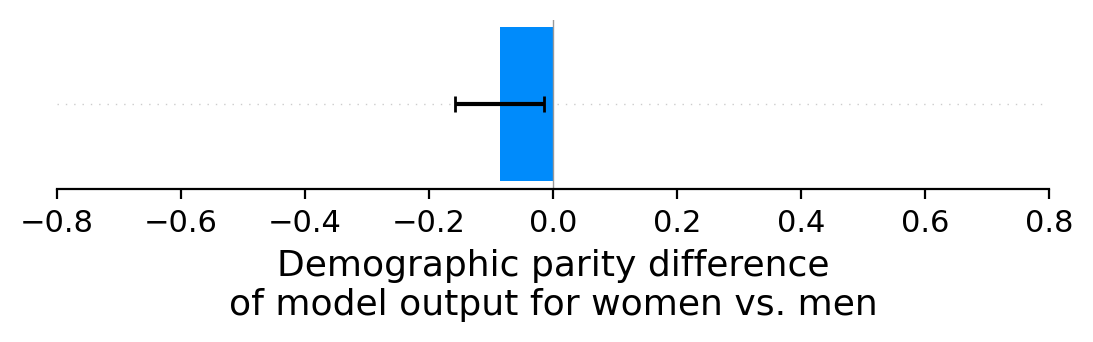

In [2]:
N = 10000
shap_values_A, sex_A, X_A, ev_A = run_credit_experiment(N)
model_outputs_A = ev_A + shap_values_A.sum(1)
glabel = "Demographic parity difference\nof model output for women vs. men"
xmin = -0.8
xmax = 0.8
shap.group_difference_plot(shap_values_A.sum(1), sex_A, xmin=xmin, xmax=xmax, xlabel=glabel)

이제 SHAP을 사용하여 모델의 각 입력 특징별로 모델 출력을 분해한 다음 각 특징에 귀속된 구성 요소의 인구통계학적 패리티 차이를 계산할 수 있습니다. 위에서 언급했듯이 SHAP 값은 모델의 출력을 합산하므로 각 특징에 대한 SHAP 값의 인구통계학적 패리티 차이의 합계는 전체 모델의 인구통계학적 패리티 차이의 합계가 됩니다. 즉, 아래 막대의 합계가 위 막대(기준 시나리오 모델의 인구통계학적 패리티 차이)와 같다는 의미입니다.

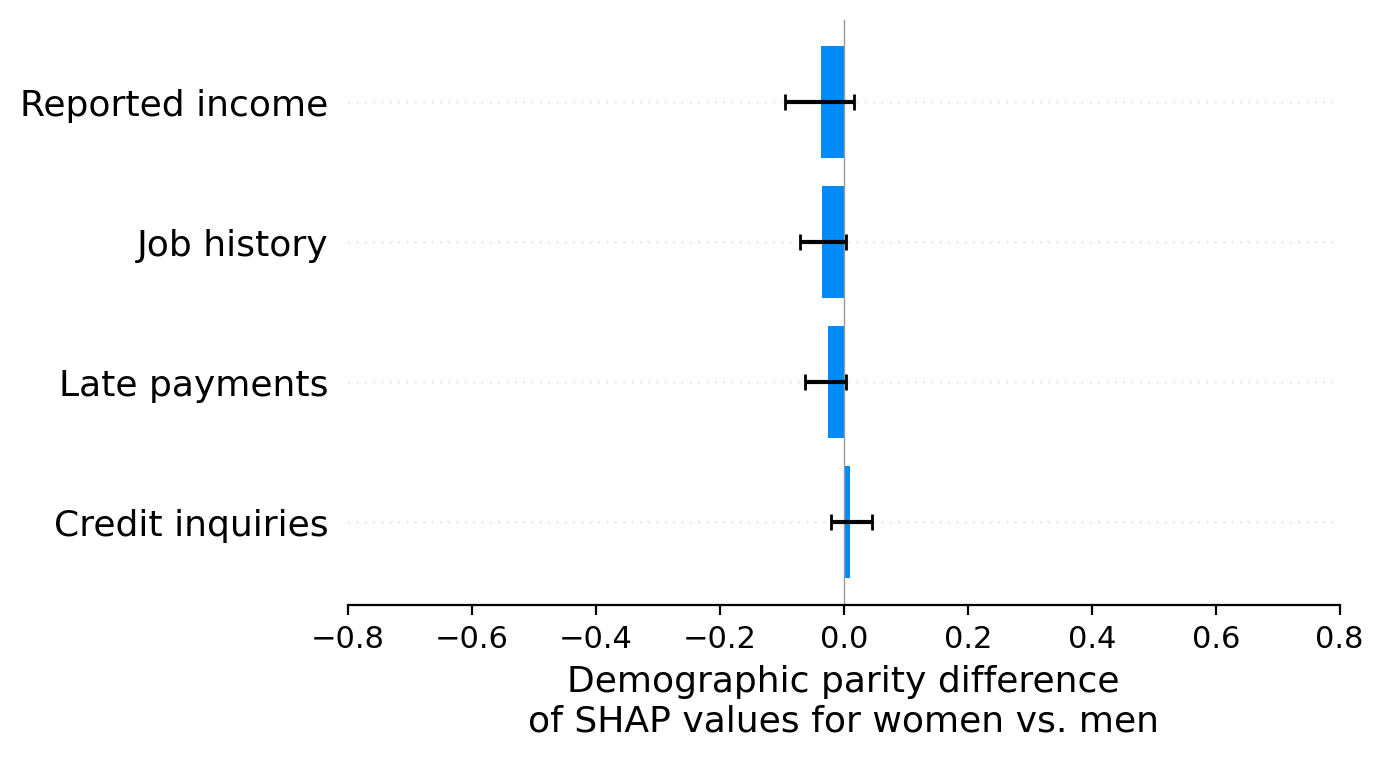

In [3]:
slabel = "Demographic parity difference\nof SHAP values for women vs. men"
shap.group_difference_plot(shap_values_A, sex_A, X_A.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

## 시나리오 B: 여성 소득에 대한 과소 보고 편견

기본 시나리오에서는 성별이 모델에서 사용하는 기능이나 레이블에 영향을 미치지 않는 시뮬레이션을 설계했습니다. 여기 시나리오 B에서는 여성 소득에 대한 과소 보고 편향을 시뮬레이션에 도입했습니다. 여기서 중요한 것은 현실 세계에서 여성의 소득이 과소 보고되는 것이 얼마나 현실적인지가 아니라 성별에 따른 편향이 도입되었음을 식별하고 그 원인을 이해하는 것입니다. 여성과 남성의 평균 모델 결과(채무 불이행 위험)의 차이를 그래프로 표시하면 소득 과소 보고 편향으로 인해 여성이 남성보다 채무 불이행 위험이 더 높은 인구 통계학적 평등 차이가 발생했음을 알 수 있습니다.:

 92%|==================  | 9196/10000 [00:11<00:00]       FixedFormatter should only be used together with FixedLocator


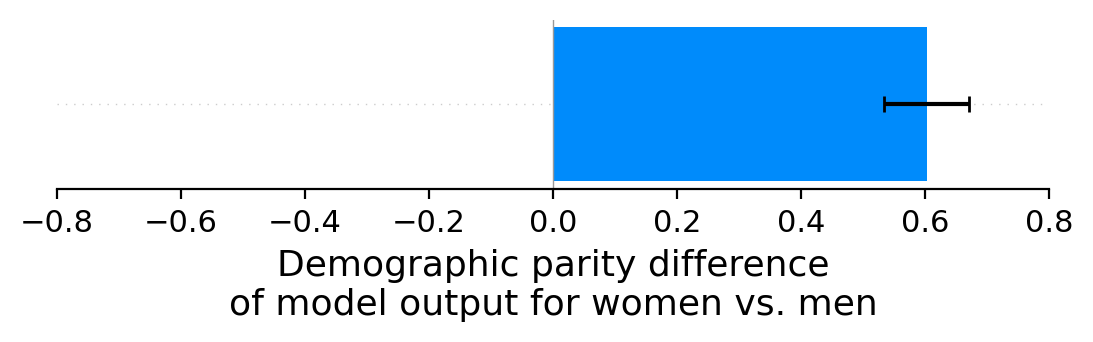

In [4]:
shap_values_B, sex_B, X_B, ev_B = run_credit_experiment(N, reported_income_sex_impact=30000)
model_outputs_B = ev_B + shap_values_B.sum(1)
shap.group_difference_plot(shap_values_B.sum(1), sex_B, xmin=xmin, xmax=xmax, xlabel=glabel)

이것이 실제 애플리케이션이라면, 이러한 인구통계학적 패리티 차이는 모델에 대한 심층 분석을 트리거하여 격차의 원인을 파악할 수 있습니다. 이러한 조사는 단일 인구통계학적 패리티 차이 값만으로는 어렵지만, SHAP에 기반한 기능별 인구통계학적 패리티를 분석하면 훨씬 더 쉽습니다. SHAP을 사용하면 보고된 소득 기능에서 여성이 남성에 비해 불균형적으로 위험을 증가시키는 상당한 편향이 있음을 알 수 있습니다. 이를 통해 어떤 특징에 보고 편향이 있어 모델이 인구통계학적 평등성을 위반하게 되는지 빠르게 식별할 수 있습니다:

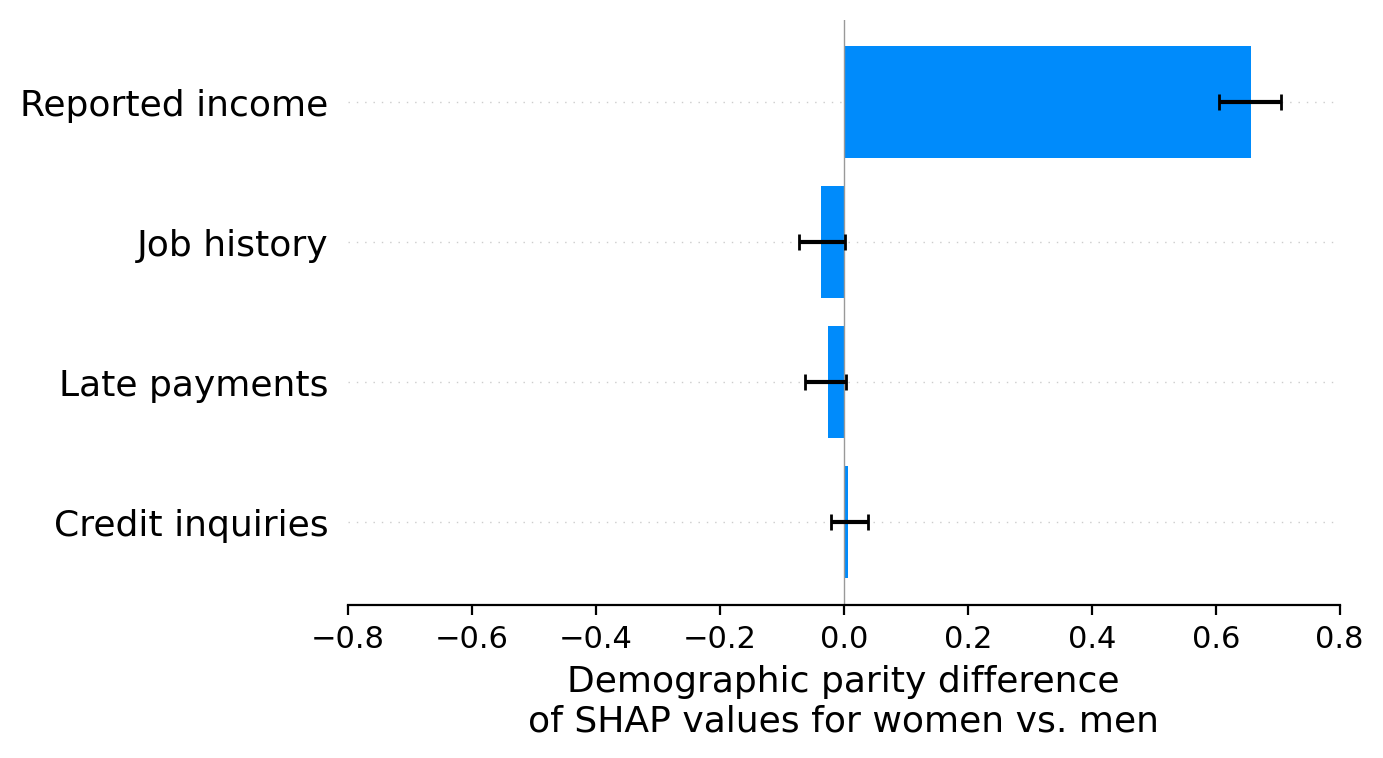

In [5]:
shap.group_difference_plot(shap_values_B, sex_B, X_B.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

이 시점에서 우리의 가정이 SHAP 공정성 설명의 해석에 어떤 영향을 미칠 수 있는지 알아두는 것이 중요합니다. 시뮬레이션 시나리오에서 여성의 소득 프로필이 실제로 남성과 동일하다는 것을 알고 있으므로, 보고된 소득 특징이 남성보다 여성에게 더 낮게 편향된 것을 볼 때, 이는 보고된 소득 특징의 측정 오류에 편향이 있기 때문이라는 것을 알 수 있습니다. 이 문제를 해결하는 가장 좋은 방법은 신고 소득 기능의 측정 오류를 제거하는 방법을 찾는 것입니다. 그렇게 하면 인구통계학적 격차가 적은 더 정확한 모델을 만들 수 있습니다. 하지만 실제로 여성이 남성보다 소득이 적다고 가정한다면(단순한 보고 오류가 아니라면), 보고된 소득 기능만 '수정'할 수는 없습니다. 대신 두 보호 대상 그룹 간의 채무 불이행 위험의 실제 차이를 가장 잘 설명할 수 있는 방법을 신중하게 고려해야 합니다. 두 경우 모두 보고된 소득 특성이 남성과 여성의 예측 위험 사이에 관찰된 격차를 유발할 수 있기 때문에 SHAP 공정성 설명만으로는 이 두 가지 상황 중 어떤 것이 발생하는지 판단하는 것은 불가능합니다.

## 시나리오 C: 여성의 연체금에 대한 과소 보고 편향

SHAP 인구통계학적 동일성 설명이 효과의 방향이나 출처 특징에 관계없이 격차를 정확하게 감지할 수 있는지 확인하기 위해 이전 실험을 반복하되, 소득에 대한 과소 보고 편향 대신 여성의 연체율에 대한 과소 보고 편향을 도입합니다. 그 결과, 모델 결과에서 인구통계학적 동일성 차이가 크게 발생하여 이제 여성이 남성보다 평균 채무 불이행 위험이 더 낮습니다:

 95%|=================== | 9465/10000 [00:11<00:00]       FixedFormatter should only be used together with FixedLocator


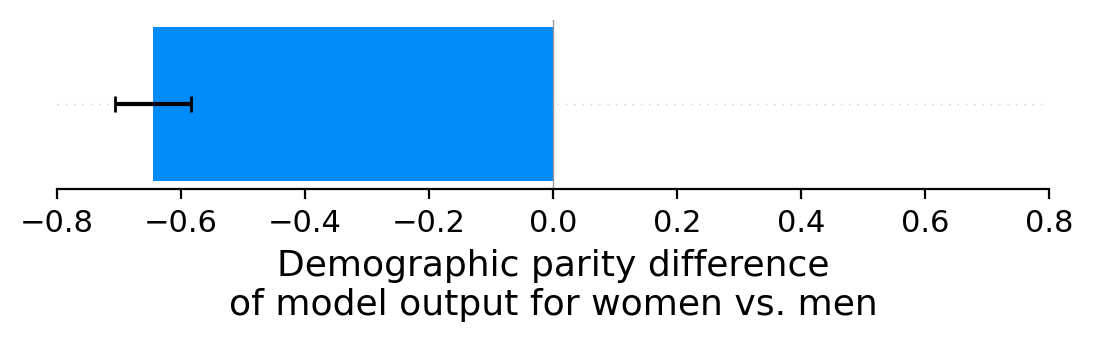

In [6]:
shap_values_C, sex_C, X_C, ev_C = run_credit_experiment(N, late_payments_sex_impact=2)
model_outputs_C = ev_C + shap_values_C.sum(1)
shap.group_difference_plot(shap_values_C.sum(1), sex_C, xmin=xmin, xmax=xmax, xlabel=glabel)

그리고 우리가 바라는 대로 SHAP 설명은 모델에서 인구통계학적 패리티 차이의 원인으로 연체금 기능을 올바르게 강조하고 그 효과의 방향을 제시합니다:그리고 우리가 바라는 대로 SHAP 설명은 모델에서 인구통계학적 패리티 차이의 원인으로 연체금 기능을 올바르게 강조하고 그 효과의 방향을 제시합니다:

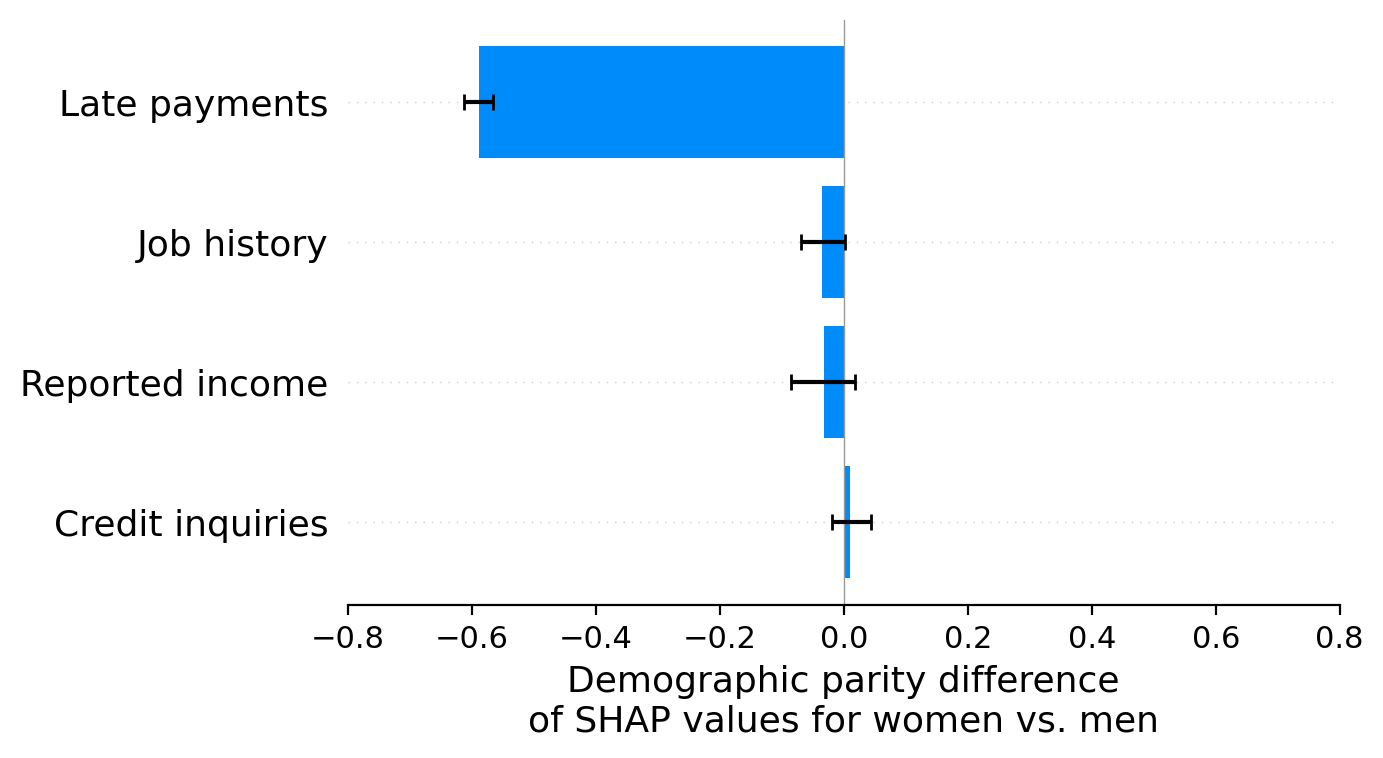

In [7]:
shap.group_difference_plot(shap_values_C, sex_C, X_C.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

## 시나리오 D: 여성 불이행률에 대한 과소 보고 편견

위의 실험에서는 특정 입력 기능에 대한 보고 오류를 도입하는 데 중점을 두었습니다. 다음으로 여성 불이행률에 대한 과소 보고 편향(즉, 여성이 남성보다 불이행이 보고될 가능성이 낮다는 의미)을 통해 학습 레이블에 보고 오류를 도입하면 어떤 일이 발생하는지 살펴보겠습니다. 흥미롭게도 시뮬레이션 시나리오에서 이 경우 모델 출력에 인구통계학적 패리티에 따른 유의미한 차이가 발생하지 않습니다:

 98%|===================| 9765/10000 [00:11<00:00]       FixedFormatter should only be used together with FixedLocator


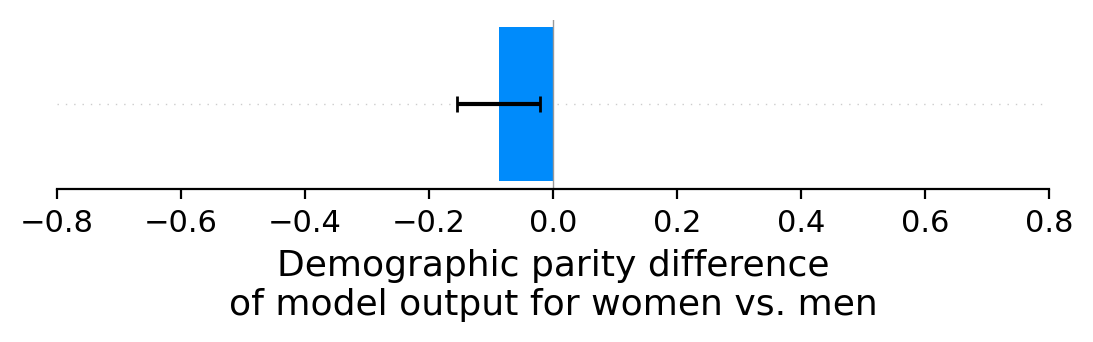

In [8]:
shap_values_D, sex_D, X_D, ev_D = run_credit_experiment(N, default_rate_sex_impact=-0.1) # 20% change
model_outputs_D = ev_D + shap_values_D.sum(1)
shap.group_difference_plot(shap_values_D.sum(1), sex_D, xmin=xmin, xmax=xmax, xlabel=glabel)

또한 SHAP 설명에서 인구통계학적 동등성 차이에 대한 증거는 발견되지 않았습니다:

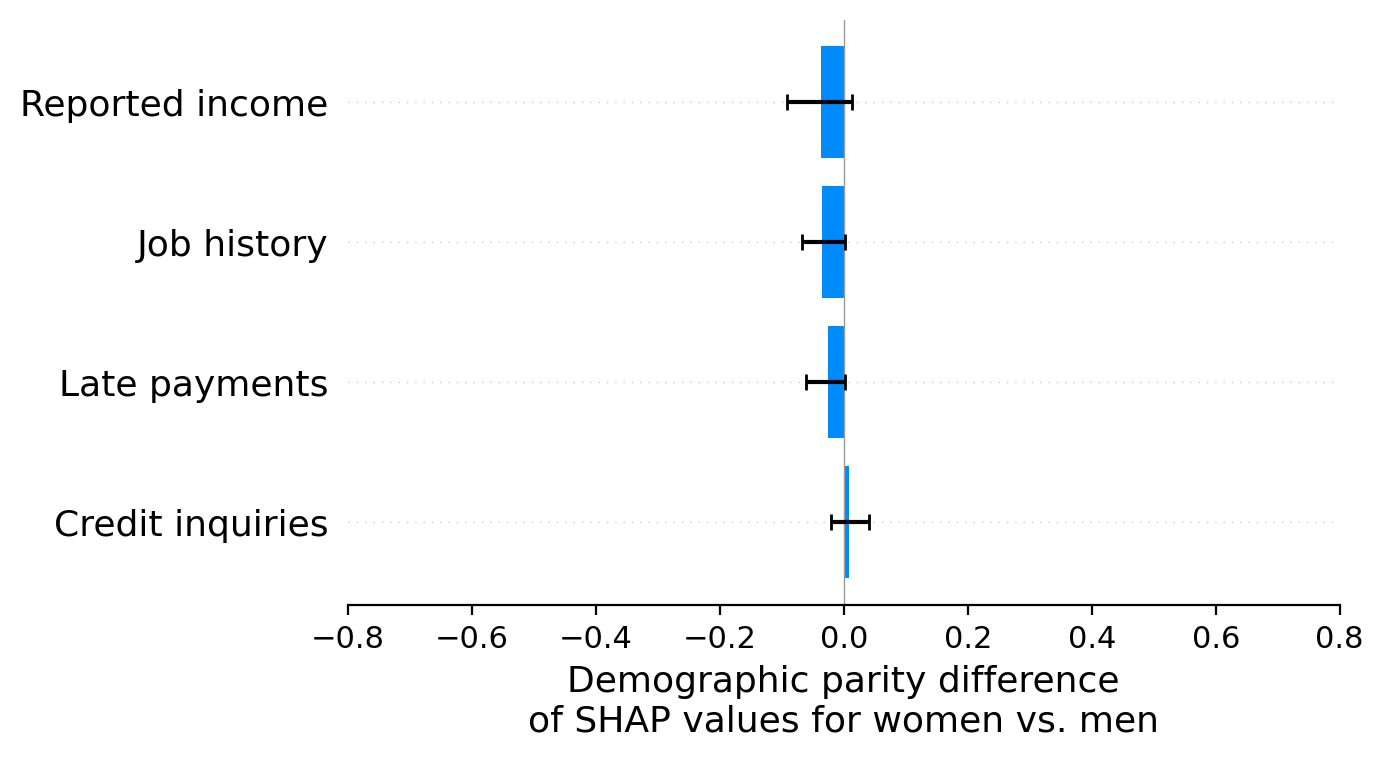

In [9]:
shap.group_difference_plot(shap_values_D, sex_D, X_D.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

## 시나리오 E: 여성 부도율에 대한 과소 보고 편향, 사례 2

여성의 불이행률에 대한 과소 보고 편향을 도입했을 때 인구통계학적 동등성 차이가 발생하지 않았다는 사실이 처음에는 놀랍게 느껴질 수 있습니다. 시뮬레이션에 사용된 네 가지 특징 중 어느 것도 성별과 유의미한 상관관계가 없기 때문에 훈련 레이블에 도입한 편향을 모델링하는 데 효과적으로 사용할 수 없었기 때문입니다. 이제 대신 성별과 상관관계가 있는 새로운 특징(브랜드 X 구매 점수)을 모델에 제공하면 모델이 해당 특징을 사용하여 학습 레이블에서 성별에 따른 편향을 포착하기 때문에 인구통계학적 패리티 차이가 나타납니다:

 99%|===================| 9911/10000 [00:12<00:00]        FixedFormatter should only be used together with FixedLocator


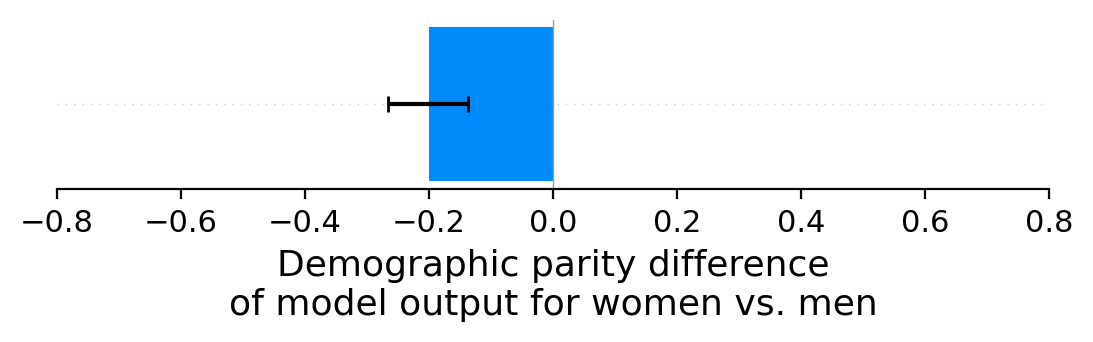

In [10]:
shap_values_E, sex_E, X_E, ev_E = run_credit_experiment(
    N, default_rate_sex_impact=-0.1, include_brandx_purchase_score=True
)
model_outputs_E = ev_E + shap_values_E.sum(1)
shap.group_difference_plot(shap_values_E.sum(1), sex_E, xmin=xmin, xmax=xmax, xlabel=glabel)

인구통계학적 패리티 차이를 SHAP으로 설명하면 예상대로 브랜드 X 구매 점수 특징이 차이를 유발하는 것을 알 수 있습니다. 이 경우 브랜드 X 구매 점수 특징을 측정하는 방식에 편향이 있기 때문이 아니라 성별과 충분히 상관관계가 있는 입력 특징에 의해 포착되는 훈련 레이블에 편향이 있기 때문입니다:

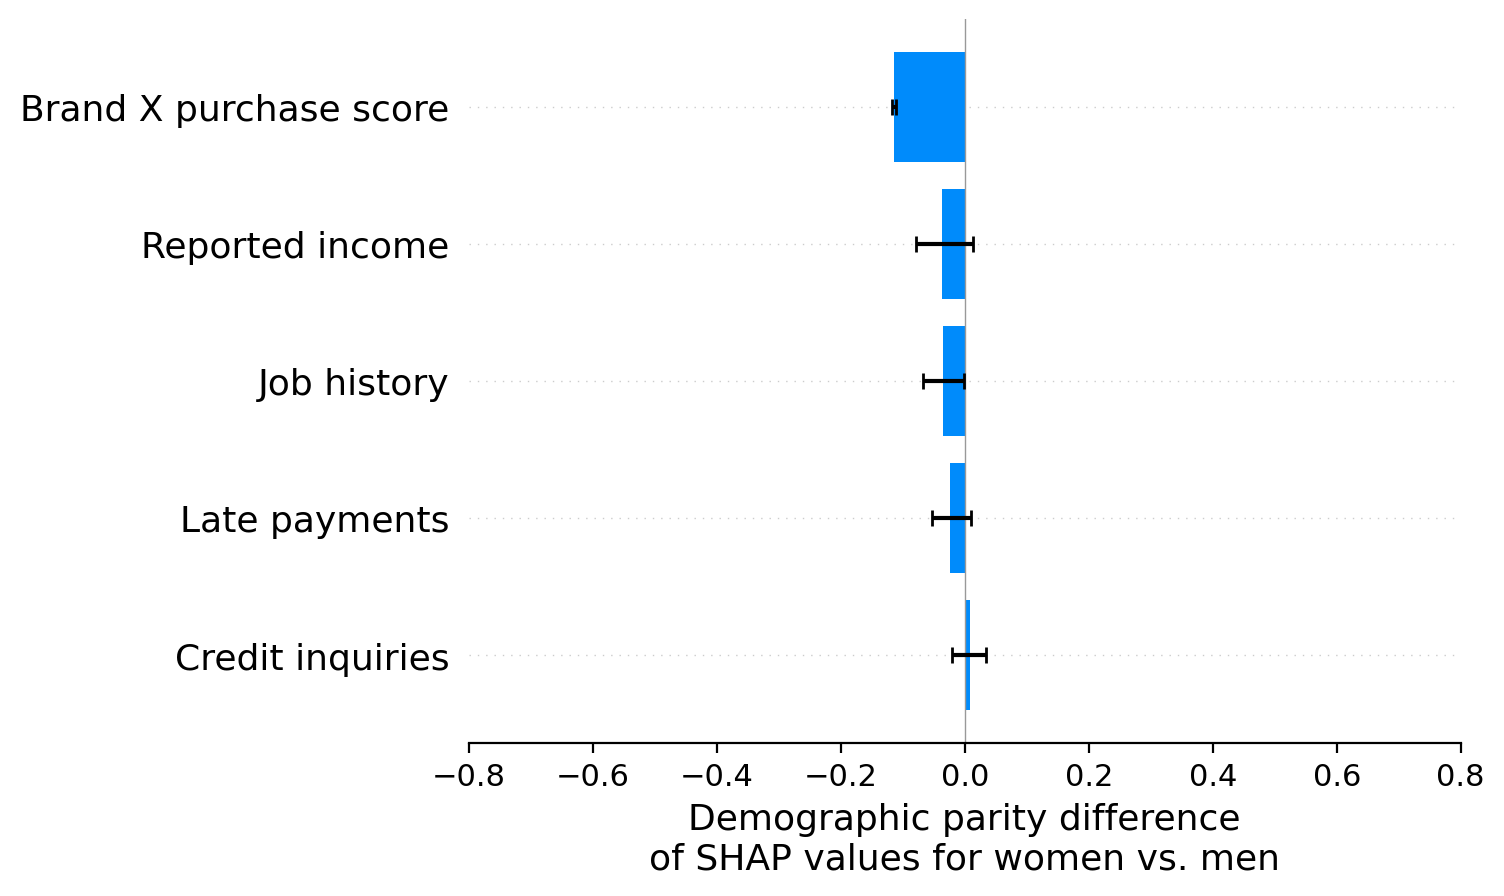

In [11]:
shap.group_difference_plot(shap_values_E, sex_E, X_E.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

## 시나리오 F: 여러 개의 과소 보고 편향 구분하기

보고 편향의 원인이 한 가지인 경우, 모델 출력에 대한 기존의 인구통계학적 동등성 테스트와 인구통계학적 동등성 테스트에 대한 SHAP 설명 모두 동일한 편향 효과를 포착합니다(단, SHAP 설명은 편향의 원인이 되는 특징을 분리하므로 통계적으로 더 유의미할 수 있습니다). 하지만 데이터 집합에 여러 가지 편향의 원인이 있는 경우에는 어떻게 될까요? 이 실험에서는 여성의 채무 불이행률에 대한 과소 보고와 여성의 직업 이력에 대한 과소 보고라는 두 가지 편향을 소개합니다. 이러한 편향은 전 세계 평균에서 서로 상쇄되는 경향이 있으므로 모델 출력에 대한 인구통계학적 동등성 테스트에서는 측정 가능한 격차가 나타나지 않습니다:

 92%|==================  | 9168/10000 [00:11<00:00]       FixedFormatter should only be used together with FixedLocator


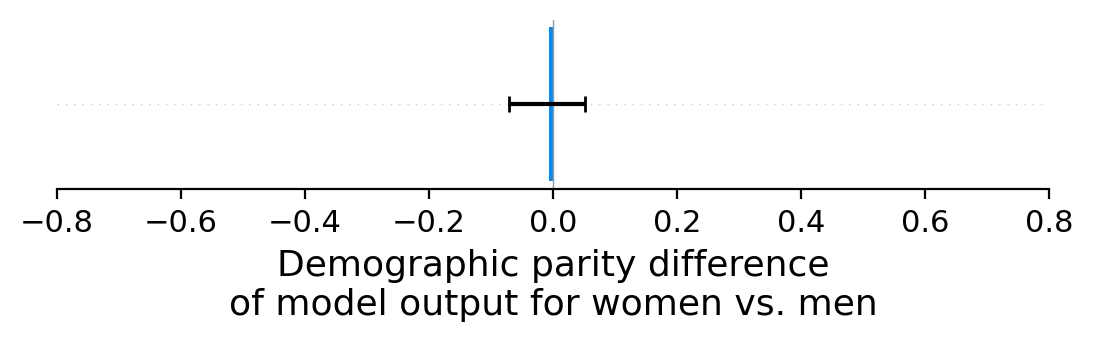

In [12]:
shap_values_F, sex_F, X_F, ev_F = run_credit_experiment(
    N, default_rate_sex_impact=-0.1, include_brandx_purchase_score=True,
    job_history_sex_impact=2
)
model_outputs_F = ev_F + shap_values_F.sum(1)
shap.group_difference_plot(shap_values_F.sum(1), sex_F, xmin=xmin, xmax=xmax, xlabel=glabel)

그러나 인구통계학적 패리티 차이에 대한 SHAP 설명을 살펴보면 두 가지 (상쇄되는) 편견을 모두 명확하게 볼 수 있습니다:

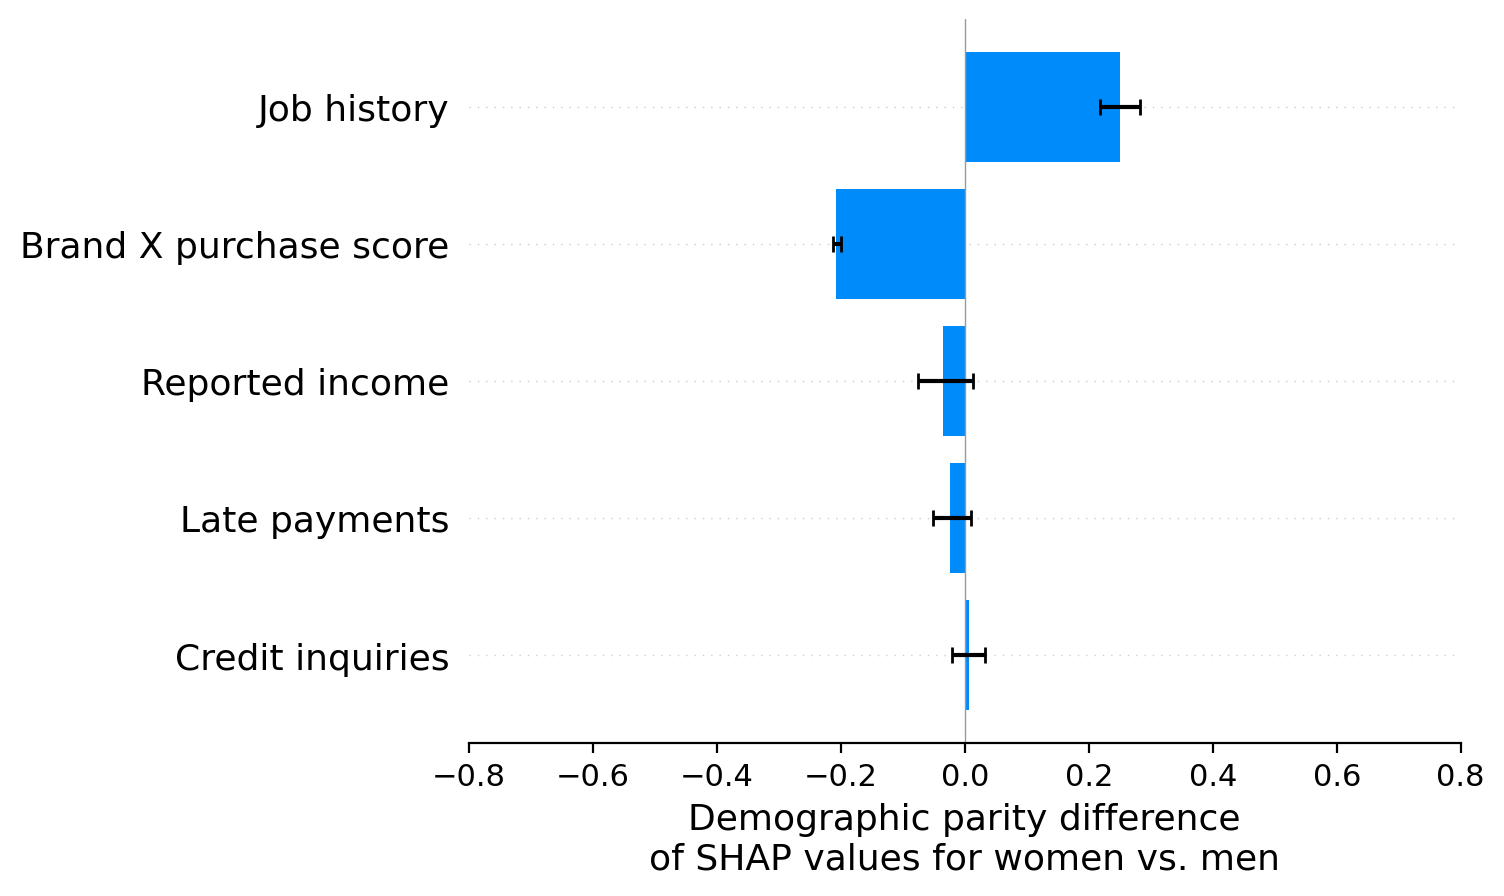

In [13]:
shap.group_difference_plot(shap_values_F, sex_F, X_F.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

평균적으로 남성이나 여성에게 미치는 영향은 다르지 않지만 개인에게 미치는 영향은 다르므로 잠재적으로 상쇄할 수 있는 여러 편향 효과를 식별하는 것이 중요할 수 있습니다. 예를 들어, 이 시뮬레이션에서 브랜드 X에서 쇼핑한 적이 없는 여성은 직업 이력 보고에 존재하는 편향으로 인해 예상보다 낮은 신용 점수를 받게 됩니다.

## 보호 기능을 도입하면 라벨 편향과 특징 편향을 구분하는 데 도움이 되는 방법

시나리오 F에서는 작업 이력 과소 보고와 기본 요율 과소 보고로 인한 두 가지 형태의 편향을 구분할 수 있었습니다. 그러나 연체율 과소 보고로 인한 편향은 연체율 라벨이 아니라 성별과 상관관계가 있는 브랜드 X 구매 점수 기능에 기인한 것으로 나타났습니다. 입력 기능에 기인한 차이는 해당 기능의 문제 또는 학습 레이블의 문제 때문일 수 있기 때문에 인구통계학적 패리티 차이의 실제 원인에 대해서는 여전히 불확실성이 남아있습니다.

이 경우 성별을 모델에 직접 변수로 도입하여 레이블 편향과 특징 편향을 분리하는 데 도움이 될 수 있다는 것이 밝혀졌습니다. 성별을 입력 특징으로 도입하는 목적은 특징 편향은 그대로 둔 채 레이블 편향이 성별 특징에만 발생하도록 하는 것입니다. 따라서 위의 시나리오 F의 결과를 아래의 새로운 시나리오 G와 비교하여 레이블 편향과 특징 편향을 구분할 수 있습니다. 물론 이렇게 하면 이전보다 훨씬 더 강력한 인구통계학적 패리티 차이가 발생하지만, 여기서 우리의 목표는 편향성 완화가 아니라 편향성을 이해하는 것이므로 괜찮습니다.

 92%|==================  | 9199/10000 [00:11<00:00]       FixedFormatter should only be used together with FixedLocator


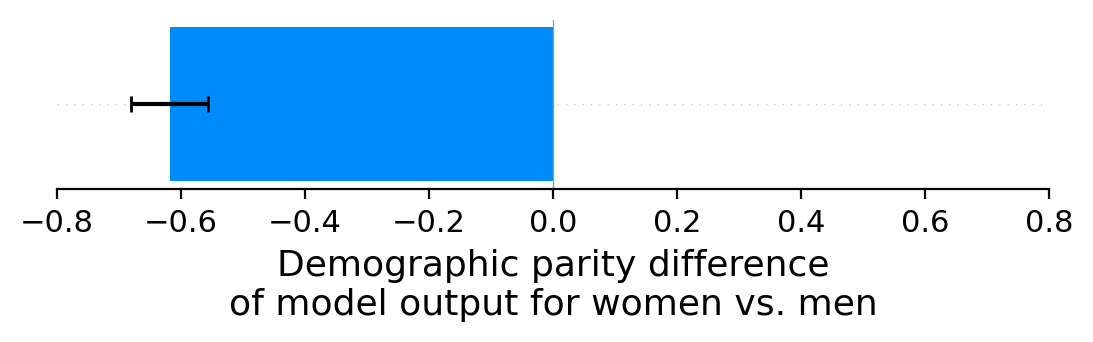

In [14]:
shap_values_G, sex_G, X_G, ev_G = run_credit_experiment(
    N, default_rate_sex_impact=-0.1, include_brandx_purchase_score=True,
    job_history_sex_impact=2, include_sex=True
)
model_outputs_G = ev_G + shap_values_G.sum(1)
shap.group_difference_plot(shap_values_G.sum(1), sex_G, xmin=xmin, xmax=xmax, xlabel=glabel)

시나리오 G에 대한 SHAP 설명에 따르면 시나리오 F에서 브랜드 X 구매 점수 기능에 첨부되었던 모든 인구통계학적 동등성 차이가 이제 성별 기능으로 이동한 반면, 시나리오 F에서 직업 이력 기능에 첨부되었던 인구통계학적 동등성 차이는 이동하지 않은 것으로 나타났습니다. 이는 시나리오 F에서 브랜드 X 구매 점수에 기인한 모든 격차는 라벨 편향으로 인한 것이지만, 시나리오 F에서 직업 이력에 기인한 모든 격차는 특징 편향으로 인한 것으로 해석할 수 있습니다.

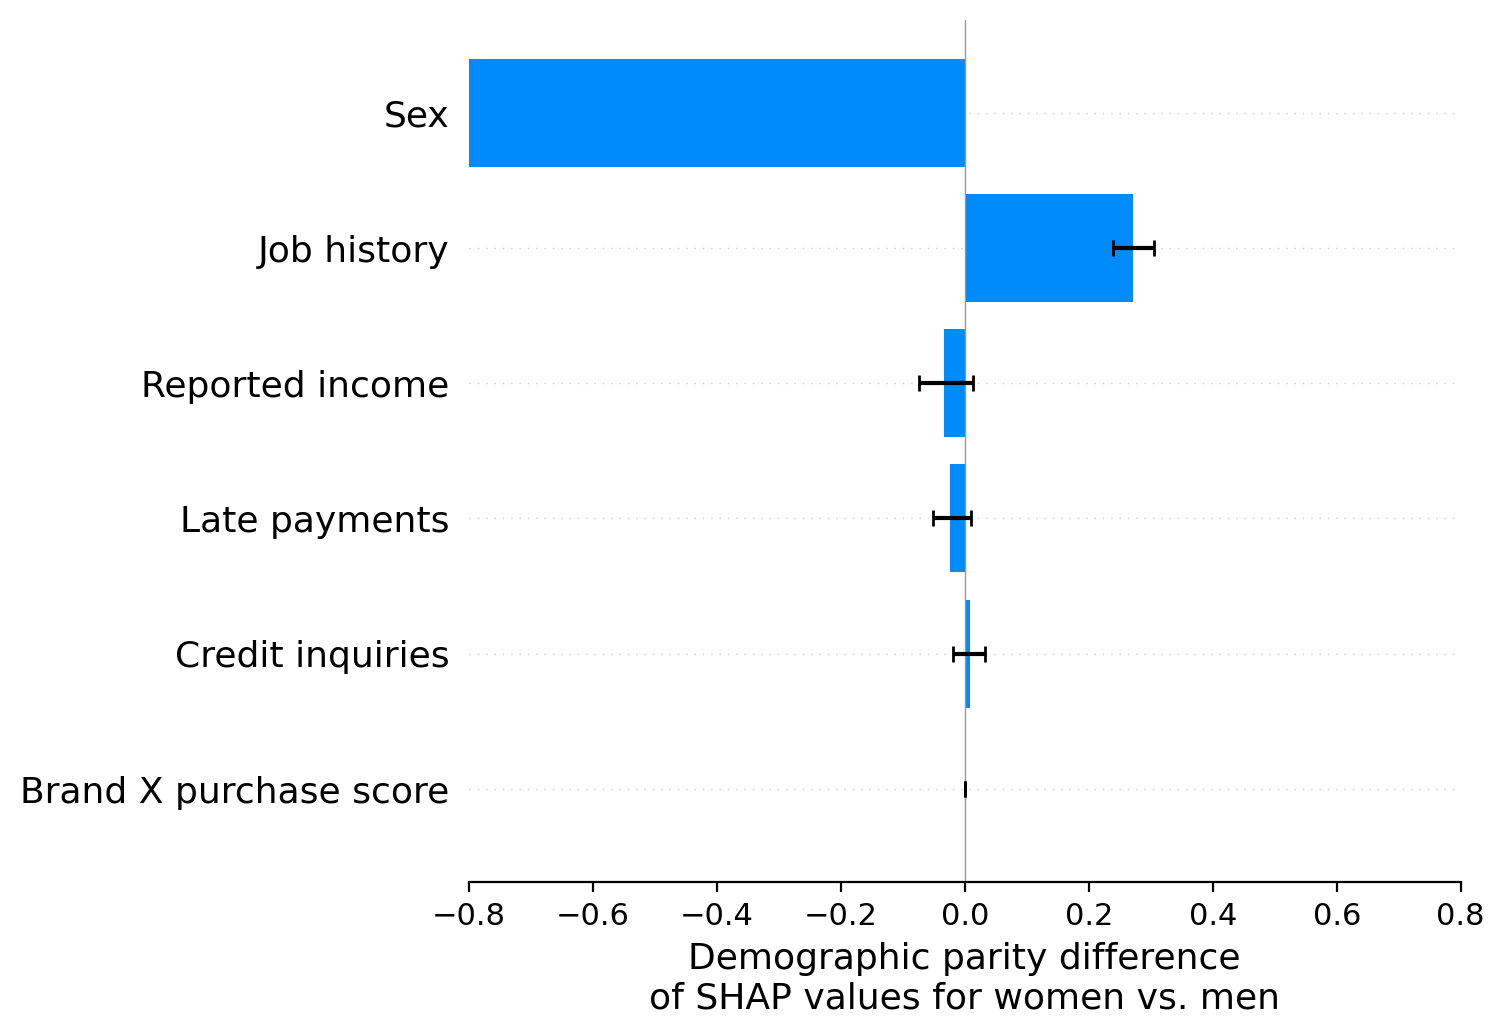

In [15]:
shap.group_difference_plot(shap_values_G, sex_G, X_G.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

## 결론
<!--## SHAP 공정성 설명에서 배울 수 없는 것들-->

공정성은 수학적 정답에는 항상 주의가 따르고 윤리적 가치 판단에 따라 달라지는 복잡한 주제입니다. 따라서 공정성 지표를 블랙박스로만 사용할 것이 아니라 이러한 지표가 어떻게 계산되는지, 모델과 학습 데이터의 어떤 측면이 관찰되는 격차에 영향을 미치는지 이해하는 것이 특히 중요합니다. 정량적 공정성 지표를 SHAP을 사용하여 분해하면 지표가 일부 기능에만 영향을 미치는 측정 편향에 의해 구동되는 경우 불투명성을 줄일 수 있습니다. 여기서 설명한 공정성 설명이 공정성 평가에 내재된 근본적인 가치 판단을 더 잘 이해하고, 실제 상황에서 공정성 지표를 사용할 때 발생하는 의도하지 않은 결과의 위험을 줄이는 데 도움이 되기를 바랍니다.